In [1]:
import numpy as np
import pandas as pd
import sys
import os
sys.path.append('../')
from Curve_fitting import GA_functions as GA
from Curve_fitting import curve_fitting as cf
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import scipy
from scipy import integrate
from scipy.stats import norm
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler

c:\Users\htchi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Summary 
This notebook is used to fit the experimental scattering curve of the polydisperse RhuA Tube-like assembly with models simulated using the MC-DFM. A genetic algorithm is used to perform the fit. The distribution of tubes of different sizes is obtained and compared to the distribution obtained from cryo-EM. 

## Load the scattering cruves 
The simulated scattering curves of the tube-like models are first loaded and plotted.

In [6]:
path = '../Data/simulated_scattering/RhuA_3/'
filenames = os.listdir(path)
filenames

['ARhuA_Monomer.npy',
 'RhuA_195.0_amp_15_start_44nm_OD.npy',
 'RhuA_225.0_amp_17_start_50nm_OD.npy',
 'RhuA_255.0_amp_19_start_56nm_OD.npy',
 'RhuA_285.0_amp_21_start_62nm_OD.npy',
 'RhuA_315.0_amp_23_start_68nm_OD.npy',
 'RhuA_345.0_amp_25_start_74nm_OD.npy',
 'RhuA_375.0_amp_27_start_80nm_OD.npy',
 'RhuA_405.0_amp_29_start_86nm_OD.npy',
 'RhuA_435.0_amp_31_start_92nm_OD.npy',
 'RhuA_465.0_amp_33_start_98nm_OD.npy',
 'RhuA_495.0_amp_35_start_104nm_OD.npy']

In [7]:
model_dict = {}
for i in range(len(filenames)):
    model_dict['model' + str(i)] = np.load(path + filenames[i])
labels_names = ['Monomer','44 nm','50 nm','56 nm','62 nm','68 nm','74 nm','80 nm','86 nm','92 nm','98 nm','104 nm']

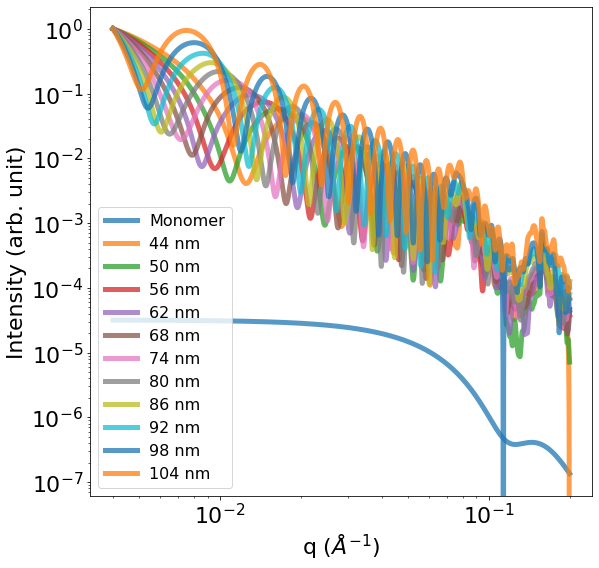

In [8]:
plt.rcParams.update({'font.size': 22})
plt.subplots(figsize=(9,9))
background = 9*10e-6
scale = 0.1

labels = []
for i in range(len(model_dict.keys())):
    plt.loglog(model_dict['model' + str(i)][:,0], model_dict['model' + str(i)][:,1], linewidth = 5, alpha = 0.75, label=labels_names[i])


plt.ylabel('Intensity (arb. unit)')
plt.xlabel('q ($\AA^{-1}$)')
plt.legend(fontsize=16)
#plt.savefig('../Images/models_curve__unscaled_cubes.png', dpi=300, bbox_inches="tight")

The invariant (https://www.sasview.org/docs/user/qtgui/Perspectives/Invariant/invariant_help.html) of the scattering curves are first determined. The invariant should be linearly proportional to the number of RhuA monomers in each tube model.

In [9]:
invariant_list = []
for keys, items in model_dict.items():
    inv = cf.invariant(items)
    invariant_list.append(inv)
invariant_array = np.array(invariant_list)

Text(0, 0.5, 'Invariant')

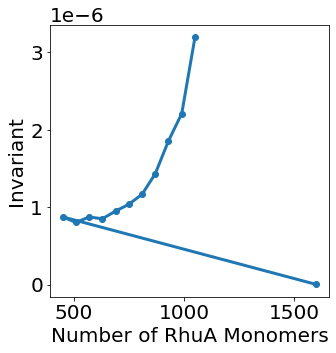

In [10]:
plt.rcParams.update({'font.size': 20})
plt.subplots(figsize=(5,5))
spheres = np.array([1/30*1600,15,17,19,21,23,25,27,29,31,33,35])*30
plt.plot(spheres, invariant_array, linewidth=3, marker='o')
plt.xlabel('Number of RhuA Monomers')
plt.ylabel('Invariant')
#plt.savefig('../Images/models_curve_unscaled_cubes_invariant.png', dpi=300, bbox_inches="tight")

The invariant is clearly not linearly proportional to the number of RhuA monomers in each tube model. To fix this, each of the scattering curves can be scaled appropriately. 

In [11]:
for i, (keys, items) in enumerate(model_dict.items()):
    model_dict[keys][:,1] = model_dict[keys][:,1]*spheres[i]/invariant_array[i]

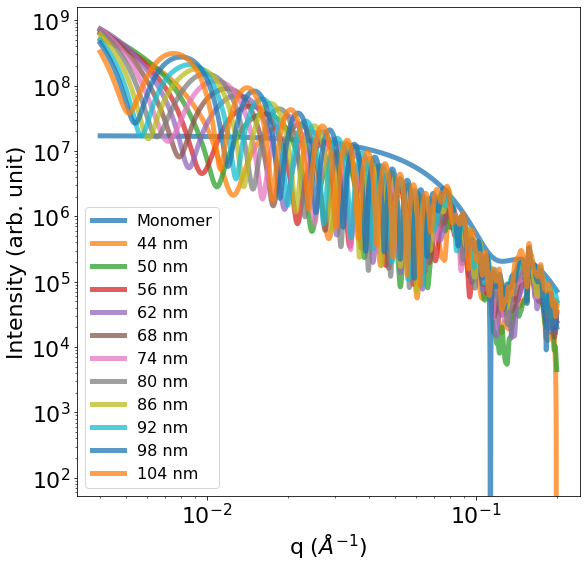

In [12]:
plt.rcParams.update({'font.size': 22})
plt.subplots(figsize=(9,9))
background = 9*10e-6
scale = 0.1

labels = []
for i in range(len(model_dict.keys()) - 0):
    if i%1 == 0:
        plt.loglog(model_dict['model' + str(i)][:,0], model_dict['model' + str(i)][:,1], linewidth = 5, alpha = 0.75, label = labels_names[i])


plt.ylabel('Intensity (arb. unit)')
plt.xlabel('q ($\AA^{-1}$)')
plt.legend(fontsize=16)
#plt.savefig('../Images/RhuA/models_curve_cubes_2.png', dpi=300, bbox_inches="tight")

Text(0, 0.5, 'Invariant')

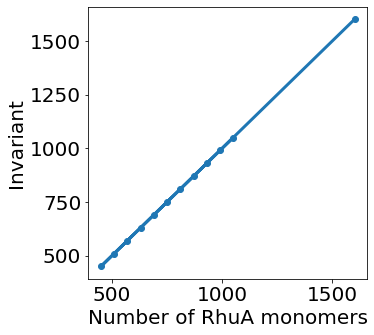

In [13]:
invariant_list = []
for keys, items in model_dict.items():
    inv = cf.invariant(items)
    invariant_list.append(inv)
invariant_array = np.array(invariant_list)

plt.rcParams.update({'font.size': 20})
plt.subplots(figsize=(5,5))
plt.plot(spheres, invariant_array, linewidth=3, marker='o')
plt.xlabel('Number of RhuA monomers')
plt.ylabel('Invariant')
#plt.savefig('../Images/models_curve_cubes_invariant.png', dpi=300, bbox_inches="tight")

The invariant is now linearly proportional to the number of RhuA monomers in each tube model. 

The experimental data is loaded. This data will be fitted with the simulated scattering curves. 

In [15]:
data = np.load('../Data/RhuA/RhuA_Exp_Data.npy')

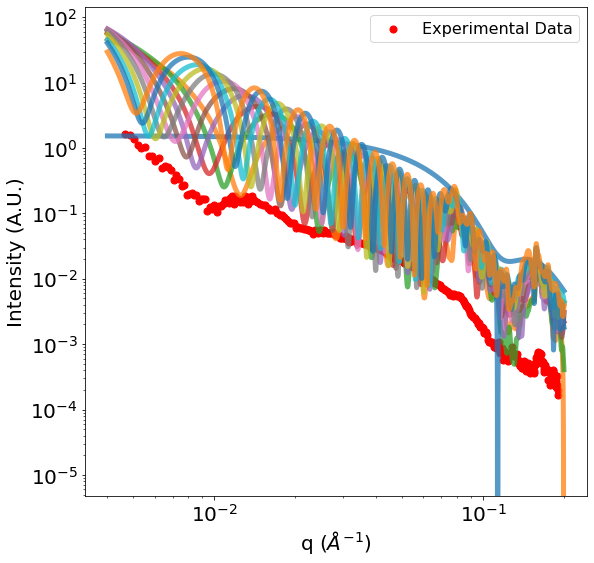

In [16]:
plt.subplots(figsize=(9,9))


for i in range(len(model_dict.keys())):
    plt.loglog(model_dict['model' + str(i)][:,0], model_dict['model' + str(i)][:,1]*9e-8, linewidth = 5, alpha = 0.75)
    
plt.scatter(data[:,0], data[:,1], label = 'Experimental Data', s = 50, color = 'red')
plt.ylabel('Intensity (A.U.)')
plt.xlabel('q ($\AA^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=16)
#plt.savefig('../Images/models_and_data.png', dpi=300, bbox_inches="tight")

The next step is to fit the experimental data with a weighted average of the simulated scattering curves of the models. The weights obtained represents the population distribution of each model in the sample. To find these weights, a genetic algorithm optimizer will be used to minimize the log mean squared error between the experimental data and the weighted average of the model scattering curves.  

A data processing step will be performed on each simulated data to ensure that all the scattering curves have the same number of data points. The variable "models" is an array of all the modeled curves, where ech column is a curve. 

In [17]:
model_dict_process = {}
for i in range(len(filenames)):
    model_dict_process['model_' + str(i)] = cf.convert_data(data, model_dict['model' + str(i)])

#q = cf.convert_data(data, model4)[:,0]
q = model_dict_process['model_0'][:,0]

for i in range(len(filenames)):
    if i == 0:
        models = model_dict_process['model_' + str(i)][:,1].reshape(-1,1)
    else:
        models = np.hstack((models, model_dict_process['model_' + str(i)][:,1].reshape(-1,1)))
    
models = models*11e-8

The code to run the genetic optmization. 

In [18]:
exp_data = data[:,1]
batch_size = 500
mutation_rate = 0.2
iterations = 500
best_solution = cf.run_optimization(exp_data, models, batch_size, mutation_rate, iterations)

In [19]:
_ , model_avg = cf.evaluate_obj_func(best_solution, models, exp_data)

From the genetic optimizaiton, the best weights for the weighted average were obtained. The model curve, which is composed of the weighted average using the best weights, is plotted with together with the experimental curve, and shows good agreement. 

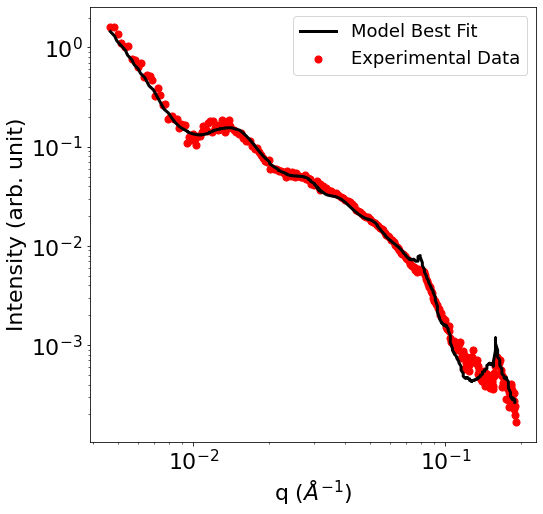

In [20]:
plt.rcParams.update({'font.size': 22})
plt.subplots(figsize=(8,8))
plt.scatter(data[:,0], exp_data, label = 'Experimental Data', s = 50, color = 'red')
#plt.scatter(q, exp_data, label = 'Experimental Data', s = 20, color = 'red')
plt.loglog(q, model_avg, label = 'Model Best Fit', linewidth = 3, alpha = 1, color = 'k')
plt.legend(loc=1, prop={'size': 18})
plt.ylabel('Intensity (arb. unit)')
plt.xlabel('q ($\AA^{-1}$)')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('../Images/RhuA/best_fit.png', dpi=300, bbox_inches="tight")

The best weights can then be plotted to show the distribution of each tube diameter in the sample.

In [21]:
#np.save('../Images/RhuA/best_model_avg.npy', np.hstack((q.reshape(-1,1), model_avg.reshape(-1,1))))

Text(0.5, 0, 'Tube Outer Diameter (nm)')

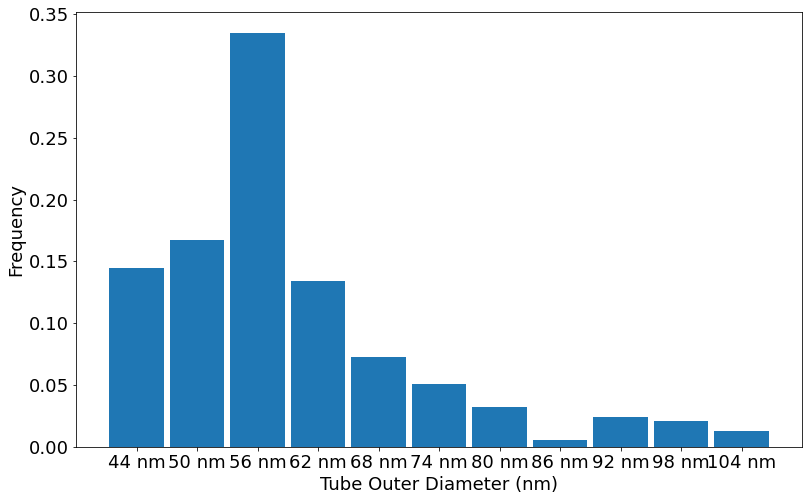

In [23]:
plt.rcParams.update({'font.size': 18})
plt.subplots(figsize=(13,8))
keys = labels_names[1:]
prop = best_solution[1:-1]
plt.bar(keys, prop/np.sum(prop), width= 0.9)
plt.ylabel('Frequency')
plt.xlabel('Tube Outer Diameter (nm)')
#plt.savefig('../Images/RhuA/best_fit_histogram.png', dpi=300, bbox_inches="tight")